In [1]:
import sys
# !!!NOTE!!! Add your own path here 
sys.path.append('/home/petar/Documents/Python/nexo_crypto/venv/lib/python3.8/site-packages')
%matplotlib inline


In [2]:
import nltk
import pandas as pd
import matplotlib
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import re
import json
from utils import get_api_data, nltk_sentiment, get_crypto_from_text, preprocess, analyse_subreddit, plot_pie_chart, \
    get_cryptos_to_analyse, summ, add_sentiment_title, add_sentiment_comment
from tqdm import tqdm
import praw




In [7]:
# !!!NOTE!!! - data/cryptos_to_analyse.json should be modified to indicate which
# 3 cryptocurrencies should be analysed

In [3]:
cryptos_to_analyse = get_cryptos_to_analyse()
api_data = get_api_data()

reddit_api = praw.Reddit(client_id=api_data['client_id'],
                         client_secret=api_data['client_secret'],
                         user_agent=api_data['user_agent'],
                         password=api_data['password'],
                         username=api_data['username'])

In [4]:
cryptos_to_analyse

['bitcoin', 'ethereum', 'cardano']

In [5]:
LIMIT = 30  # This indicates how many subreddits to fetch

In [6]:
top_posts = reddit_api.subreddit('CryptoCurrency').top('day', limit=LIMIT)  # Fetch the top daily posts (using LIMIT as indicator of how many of them, if all needed - just set it to float(inf)


In [7]:
subreddits = []
txt_lens = []
coin_counts = {cryptos_to_analyse[0]: 0, cryptos_to_analyse[1]: 0, cryptos_to_analyse[2]: 0}  # Set all counts to 0
freqdist_list = []

In [8]:
for j, subreddit in enumerate(tqdm(top_posts, total=LIMIT,
                                   desc='Processing subreddits...')):

    subreddit_title_preprocessed = preprocess(subreddit.title)

    subreddit_parsed = {'title_data': {'title': subreddit_title_preprocessed, 'cryptos': [], 'sentiment': None},
                        'comments_data': {'comments': [], 'cryptos': [], 'sentiments': []}}

    subreddit_parsed['title_data']['cryptos'] = list(get_crypto_from_text(subreddit_title_preprocessed))
    subreddit_parsed['title_data']['sentiment'] = nltk_sentiment(subreddit_title_preprocessed)

    subreddit_comm = reddit_api.submission(id=subreddit.id)
    comments = subreddit_comm.comments

    for count, top_level_comment in enumerate(comments):
        try:
            top_level_comment_preprocessed = preprocess(top_level_comment.body)
            subreddit_parsed['comments_data']['comments'].append(top_level_comment_preprocessed)
            subreddit_parsed['comments_data']['cryptos'].append(
                list(get_crypto_from_text(top_level_comment_preprocessed)))
            subreddit_parsed['comments_data']['sentiments'].append(nltk_sentiment(top_level_comment_preprocessed))

        except:
            # The code goes in this block, because for some reason there is a "MoreComments" object, which I will inspect a bit later. It has some useless ids, and not real comments, so I am ignoring it for now.
            # print('Problem with comment, ignoring it...')
            continue

    comment_cryptos = [crypto for crypto_list in subreddit_parsed['comments_data']['cryptos'] for crypto in
                       crypto_list]  # Here we fetch a list of ALL cryptos seen in the comments of as specific subreddit/thread
    title_cryptos = subreddit_parsed['title_data']['cryptos']  # Same for the ittle
    all_cryptos = [*title_cryptos, *comment_cryptos]  # Union them

    if bool(set(cryptos_to_analyse) & set(
            all_cryptos)):  # Here we check whether the thread contains any of the three coins that we specify (in other words, whether the two sets overlap)

        txt_len, curr_coin_count, frequencies = analyse_subreddit(subreddit_parsed, j)
        freqdist_list.append(frequencies)
        for c in cryptos_to_analyse:
            coin_counts[c] += curr_coin_count[c]
        txt_lens.append(txt_len)
        subreddits.append(subreddit_parsed)  # if yes, we consider that subreddit for analysis


Processing subreddits...: 100%|█████████████████████████████████████████████| 30/30 [01:06<00:00,  2.23s/it]


In [14]:
sentiment_analysis = {}  # This will contain the sentiments for different coins for the day. We can further separate titles and comments sentiments (if titles have different influence), but for now let's keep it simple
print('Coin counts: ', coin_counts)

Coin counts:  {'bitcoin': 289, 'ethereum': 120, 'cardano': 17}


In [25]:
all_frequencies = summ(freqdist_list)

In [26]:
for subreddit in subreddits:
    title_cryptos = subreddit['title_data']['cryptos']
    comments_cryptos = subreddit['comments_data']['cryptos']

    sentiment_analysis = add_sentiment_title(title_cryptos, sentiment_analysis, subreddit)
    sentiment_analysis = add_sentiment_comment(comments_cryptos, sentiment_analysis, subreddit)

In [27]:
sentiment_analysis

{'cardano': {'positive': 8, 'negative': 1, 'neutral': 6},
 'bitcoin': {'positive': 106, 'negative': 32, 'neutral': 66},
 'ethereum': {'positive': 45, 'negative': 12, 'neutral': 42}}

In [28]:
pos = [sentiment_analysis[key]['positive'] for key in sentiment_analysis.keys()]
neg = [sentiment_analysis[key]['negative'] for key in sentiment_analysis.keys()]
neu = [sentiment_analysis[key]['neutral'] for key in sentiment_analysis.keys()]
idx = list(sentiment_analysis.keys())
df = pd.DataFrame({'positive': pos, 'negative': neg, 'neutral': neu}, index=idx)

In [29]:
df

,positive,negative,neutral
cardano,8,1,6
bitcoin,106,32,66
ethereum,45,12,42


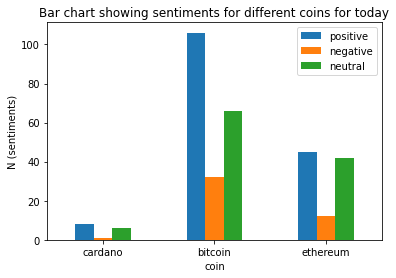

In [31]:
# Now let's do some plotting
ax = df.plot.bar(rot=0, title='Bar chart showing sentiments for different coins for today')
ax.set_xlabel('coin')
ax.set_ylabel('N (sentiments)')
fig = ax.get_figure()
plt.show()

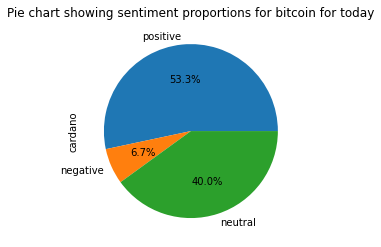

In [33]:
# Pie chart for first
try:
    plot_pie_chart(df.iloc[0], cryptos_to_analyse[0], plt)
except:
    print(f'Missing values for {cryptos_to_analyse[0]}')

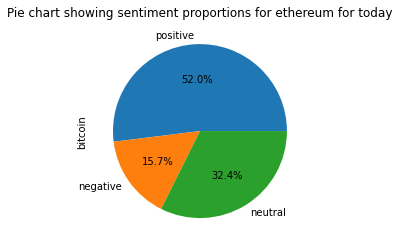

In [34]:
# Pie chart for second coin
try:
    plot_pie_chart(df.iloc[1], cryptos_to_analyse[1], plt)
except:
    print(f'Missing values for {cryptos_to_analyse[1]}')

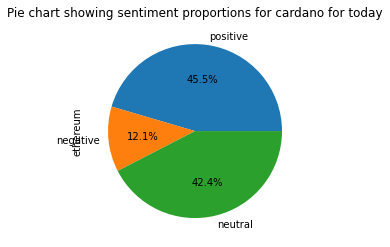

In [35]:
# Pie chart for third coin
try:
    plot_pie_chart(df.iloc[2], cryptos_to_analyse[2], plt)
except:
    print(f'Missing values for {cryptos_to_analyse[2]}')

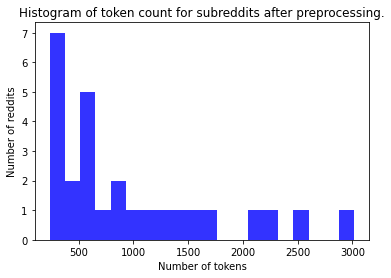

In [42]:
# Plot distribution of number of tokens (this is meaningful for more sophisticated analysis)
num_bins = 20
fig = plt.hist(txt_lens, num_bins, facecolor='blue', alpha=0.8)
plt.title('Histogram of token count for subreddits after preprocessing.')
plt.xlabel('Number of tokens')
plt.ylabel('Number of reddits')
plt.show()
plt.close()

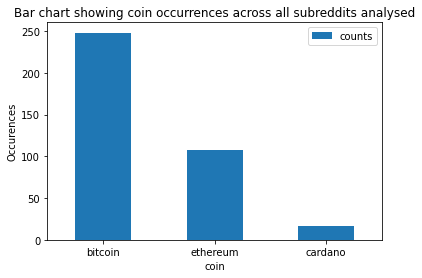

In [39]:
# Plot distribution of crypto occurences
df = pd.DataFrame({'counts': list(coin_counts.values())}, index=list(coin_counts.keys()))
ax = df.plot.bar(rot=0, title='Bar chart showing coin occurrences across all subreddits analysed')
ax.set_xlabel("coin")
ax.set_ylabel('Occurences')
fig = ax.get_figure()
plt.show()

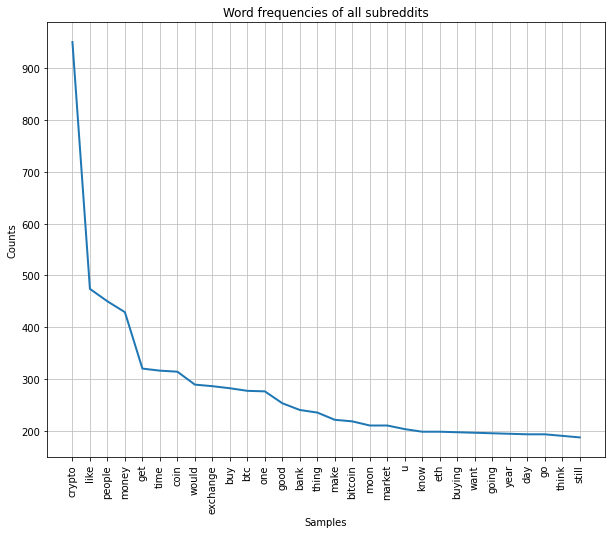

In [40]:
# Plot all frequencies
fig = plt.figure(figsize=(10, 8))
all_frequencies.plot(30, cumulative=False, show=False,
                     title=f'Word frequencies of all subreddits')  # Don't show it, just save it to the file
fig.savefig(f'visualization/all_word_frequencies.png')
plt.show()
plt.close()